## Notebook to apply sst binning to all data from wind lidar, raman lidar, cloud radar etc 

In [1]:
# importing necessary libraries
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.dates as mdates
import glob
#from myFunctions import lcl
#from myFunctions import f_closest
from warnings import warn
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from scipy import interpolate
import custom_color_palette as ccp
from matplotlib import rcParams
import matplotlib.ticker as ticker


def f_interpolate_SST_and_merge(SST_DS, dataset_obs):
    '''function to interpolate SST values on the time resolution of the observations given as input
    input: 
    SST_DS: xarray dataset containing sst values
    dataset_obs: xarray dataset containing the observations to merge with sst data
    output: 
    data_merged: data returned 
    '''
    
    # interpolating sst data at 1 min resolution to the 10 s res of the wind lidar
    sst_data_interp = SST_DS.interp(time=dataset_obs['time'].values)

    # merging the interpolated dataset and the wind lidar dataset
    data_merged = xr.merge([dataset_obs, sst_data_interp])
    return(data_merged)


def f_calculate_binned_data(data_input, SST_binned_arr):
    
    ''' function to calculate mean values of all variables for each SST bin, for all instruments
    author: Claudia Acquistapace
    date: 20 Sept 2021
    input: - data_input: input xarray dataset containing the variables as a function of time, height, to be averaged
            - SST_binned_arr: numpy array of sst binned values for calculating the mean 
    output: dataset_concat: xarray dataset of concatenated values with mean profiles corresponding to the sst bins. A variable n_el counts the number of profiles averaged together
    '''
    # calculating mean quantities f
    dataset_mean = []

    data_input = data_input.load()

    # selecting all columns in the bin interval
    for ind_bin in range(len(SST_binned_arr)-1):

        # selecting slices of datasets columns with SST values in the selected bin
        DS_sliced = data_merged.where((data_input.SST > SST_binned_arr[ind_bin]) & (data_input.SST < SST_binned_arr[ind_bin+1]), drop=True)

        # add variable of the number of elements of the slice
        n_el = len(DS_sliced.SST.values)
        DS_sliced['n_elements'] = n_el

        # calculate mean profile averaging all selected time stamps together
        dataset_mean.append(DS_sliced.mean(dim='time', skipna=True))


    # concatenating datasets corresponding to SST bins on a new bin dimension
    dataset_concat = xr.concat([dataset_mean[i] for i in np.arange(len(dataset_mean))], dim='SST_binned')
    return(dataset_concat)




dict_plot_settings = {
    'labelsizeaxes':14,
    'fontSizeTitle':16,
    'fontSizeX'    :16,
    'fontSizeY'    :16,
    'cbarAspect'   :10,
    'fontSizeCbar' :16,
    'rcparams_font':['Tahoma'],
    'savefig_dpi'  :100,
    'font_size'    :22, 
    'grid'         :True}




data_path = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/arthus_data/post_processed_clau/'
tsg_file = "/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/tsg_sst_data/tsg/nc/msm_089_1_tsg.nc"
path_out_plots = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/SST_impact_work/plots/'


reading data from tsg and create SST dataset

In [2]:
# reading tsg file ( data with 1 min resolution)
tsg_data = xr.open_dataset(tsg_file)

# identifying time stamps of sst corresponding to time stamps of radiosondes
t_start = datetime(2020, 2, 2, 0, 0, 0)
t_end = datetime(2020, 2, 3, 23, 59, 59)

# slicing tsg datase t for the selected time interval and extracting sst
sliced_tsg_ds = tsg_data.sel(TIME=slice(t_start, t_end))
tsg_sst = sliced_tsg_ds['TEMP'].values
tsg_time_sst = sliced_tsg_ds['TIME'].values
tsg_flag = sliced_tsg_ds['TEMP_QC'].values

# averaging together the sst of the different sst sensors for tsg
temp0 = sliced_tsg_ds.TEMP[:,0].values
temp1 = sliced_tsg_ds.TEMP[:,1].values
sst_tsg = temp0
sst_tsg[np.isnan(temp0)] = temp1[np.isnan(temp0)]

# producing output dataset of sst_tsg for the selected time window
# creating dataset with coordinates sst and height
dim_sst           = ['time']
coords         = {"time":sliced_tsg_ds.TIME.values}
SST              = xr.DataArray(dims=dim_sst, coords=coords, data=sst_tsg,
                 attrs={'long_name':'sea surface temperature ',
                        'units':'$^{\circ}$C'})
variables         = {'SST':SST}
SST_DS      = xr.Dataset(data_vars = variables,
                       coords = coords)


definition of the functions for: 
- Interpolation of the SST on the time grid of each instrument
- binning of the data over SST grid


In [3]:
# building SST binned array
SST_min = np.nanmin(sst_tsg)
SST_max = np.nanmax(sst_tsg)
SST_binned_arr = np.arange(SST_min, SST_max, step=0.025)


# calculate label marks for bins
sst_bin_label = []
for ind in range(len(SST_binned_arr)-1):
    sst_bin_label.append(round((SST_binned_arr[ind]+SST_binned_arr[ind+1])/2,2))
    


Reading data from Arthus for T, wvmr, SHF, LHF.

In [4]:
# reading all arthus data 

# variable list
var_list =['T','WVMR','VW','LHF','SHF']

T_dict = {
     'var_name'  : 'T',
     'var_string': 'Temperature',
     'var_units' : ' $^{\circ}$K',
     'var_min'   : 290.,
     'var_max'   : 310.,
     'thr_min'   : 280.,
     'thr_max'   : 330.,
     'avg_time'  : '15',
     'cmap'      : 'jet',
     'title'     : 'Air temperature: 28/01-04/02'}

WVMR_dict = {
     'var_name'  : 'MR',
     'var_string': 'Water vapor mixing ratio',
     'var_units' : ' g kg$^{-1}$',
     'var_min'   : 0.,
     'var_max'   : 30.,
     'thr_min'   : 0.,
     'thr_max'   : 30.,
     'avg_time'  : '15',
     'cmap'      : 'jet',
     'title'     : 'Water vapor mixing ratio: 28/01-04/02'}

VW_dict = {
     'var_name'  : 'VW',
     'var_string': 'Vertical velocity',
     'var_units' : ' ms$^{-1}$',
     'var_min'   : -2.,
     'var_max'   : 2.,
     'thr_min'   : -5.,
     'thr_max'   : 5.,
     'avg_time'  : '15',
     'cmap'      : 'seismic',
     'title'     : 'Vertical velocity: 28/01-04/02'}

LHF_dict = {
     'var_name'  : 'LHF',    
     'var_string': 'Latent heat flux',
     'var_units' : ' W m$^{-2}$',
     'var_min'   : -250.,
     'var_max'   : 250.,
     'thr_min'   : -250.,
     'thr_max'   : 250.,
     'avg_time'  : '30',
     'cmap'      : 'jet',
     'title'     : 'Latent heat flux: 28/01-04/02'}

SHF_dict = {
     'var_name'  : 'SHF',
     'var_string': 'Sensible heat flux',
     'var_units' : ' W m$^{-2}$',
     'var_min'   : -100.,
     'var_max'   : 100.,
     'thr_min'   : -100.,
     'thr_max'   : 100.,
     'avg_time'  : '30',
     'cmap'      : 'jet',
     'title'     : 'Sensible heat flux: 28/01-04/02'}


dict_list = [T_dict, WVMR_dict, VW_dict, LHF_dict, SHF_dict]



vars_arthus = []

for i_var, dict_var in enumerate(dict_list):

    print('processing variable: ', dict_var['var_string'])
    
    # reading file list of the files for the selected variable
    arthus_file_list = np.sort(glob.glob(data_path+dict_var['var_name']+'*.nc'))

    # read the two datasets together
    arthus_dataset = xr.open_mfdataset(arthus_file_list)
    
    # renaming variable time and height and dimension time and height (step necessary for next operations)
    arthus_dataset = arthus_dataset.rename_dims({'Time':'time'})
    arthus_dataset = arthus_dataset.rename_dims({'Height':'height'})
    arthus_dataset = arthus_dataset.rename_vars({'Time':'time'})
    arthus_dataset = arthus_dataset.rename_vars({'Height':'height'})


    # interpolating SST data on the arthus data 
    arthus_all_SST = f_interpolate_SST_and_merge(SST_DS, arthus_dataset)

    # calculating mean quantities for each bin
    dataset_mean = []
    dataset_std = []

    # selecting all columns in the bin interval
    for ind_bin in range(len(SST_binned_arr)-1):

        # selecting slices of datasets columns with SST values in the selected bin
        DS_sliced = arthus_all_SST.where((arthus_all_SST.SST > SST_binned_arr[ind_bin]) & (arthus_all_SST.SST < SST_binned_arr[ind_bin+1]), drop=True)


        # add variable of the number of elements of the slice
        n_el = len(DS_sliced.SST.values)
        DS_sliced['n_elements'] = n_el

        # calculate mean profile averaging all selected time stamps together
        dataset_mean.append(DS_sliced.mean(dim='time', skipna=True))
        dataset_std.append(DS_sliced.std(dim='time', skipna=True))

    # concatenating datasets corresponding to SST bins on a new bin dimension
    arthus_SST_concat = xr.concat([dataset_mean[i] for i in np.arange(len(dataset_mean))], dim='SST_binned')
    arthus_SST_std_concat = xr.concat([dataset_std[i] for i in np.arange(len(dataset_std))], dim='SST_binned')
    
    # saving variable of interest in a dictionary with its name
    dict_variable_nodc = {'var_name':dict_var['var_name'],
                     'var':arthus_SST_concat['product_no_diurnal_cycle'].values}

    
    
    # append the dictionary in a list of dictionaries containing all arthus variables
    vars_arthus.append(dict_variable_nodc)

    
# converting the list of dictionaries in a dictionary called variables to be saved in ncdf
dims             = ['sst','height']
coords           = {'sst':SST_binned_arr[0:-1], 'height':arthus_SST_concat['height'].values}
variables = {}
for i in range(len(dict_list)):
    key = vars_arthus[i]['var_name']
    value = xr.DataArray(dims=dims, coords=coords, data=vars_arthus[i]['var'],
                             attrs={'long_name':vars_arthus[i]['var_name']+' without diurnal cycle',
                                    'units':dict_var['var_units']})

    variables[key] = value

    

global_attributes = {'CREATED_BY'       : 'Claudia Acquistapace',
                        'CREATED_ON'       :  str(datetime.now()),
                        'FILL_VALUE'       :  'NaN', 
                        'PI_NAME'          : 'Claudia Acquistapace',
                        'PI_AFFILIATION'   : 'University of Cologne (UNI), Germany', 
                        'PI_ADDRESS'       : 'Institute for geophysics and meteorology, Pohligstrasse 3, 50969 Koeln', 
                        'PI_MAIL'          : 'cacquist@meteo.uni-koeln.de',
                        'DATA_DESCRIPTION' : dict_var['var_string']+'with the diurnal cycle removed from the data',
                        'DATA_DISCIPLINE'  : 'Atmospheric Physics - Remote Sensing Lidar Profiler',
                        'DATA_GROUP'       : 'Experimental;Profile;Moving',
                        'DATA_SOURCE'      : 'arthus data',
                        'DATA_PROCESSING'  : 'https://github.com/ClauClouds/SST-impact/',
                        'INSTRUMENT_MODEL' : 'arthus raman lidar system',
                         'COMMENT'         : 'original data postprocessed by Diego Lange' }
dataset_out    = xr.Dataset(data_vars = variables,
                        coords = coords,
                        attrs = global_attributes)
dataset_out.to_netcdf('/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/arthus_data/post_processed_clau/arthus_binned_sst.nc')



processing variable:  Temperature


/Users/claudia/opt/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


processing variable:  Water vapor mixing ratio


/Users/claudia/opt/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


processing variable:  Vertical velocity


/Users/claudia/opt/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


processing variable:  Latent heat flux


/Users/claudia/opt/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


processing variable:  Sensible heat flux


/Users/claudia/opt/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [5]:
dataset_out

<xarray.Dataset>
Dimensions:  (height: 57, sst: 55)
Coordinates:
  * sst      (sst) float64 26.28 26.31 26.33 26.36 ... 27.56 27.58 27.61 27.63
  * height   (height) float32 225.0 275.0 325.0 375.0 ... 2925.0 2975.0 3025.0
Data variables:
    T        (sst, height) float64 -1.021 -0.939 -0.3595 ... 1.474 nan nan
    MR       (sst, height) float64 0.1945 0.09832 0.03744 ... -5.818 nan nan
    VW       (sst, height) float64 0.1155 0.1371 0.1555 ... -0.3213 nan nan
    LHF      (sst, height) float64 7.88 1.835 -8.985 22.22 ... -42.32 nan nan
    SHF      (sst, height) float64 -16.65 -20.19 16.47 14.44 ... nan nan nan nan
Attributes:
    CREATED_BY:        Claudia Acquistapace
    CREATED_ON:        2021-11-30 17:51:12.642000
    FILL_VALUE:        NaN
    PI_NAME:           Claudia Acquistapace
    PI_AFFILIATION:    University of Cologne (UNI), Germany
    PI_ADDRESS:        Institute for geophysics and meteorology, Pohligstrass...
    PI_MAIL:           cacquist@meteo.uni-koeln.de
    DATA_DESCRIPTION:  Sensible heat fluxwith the diurnal cycle removed from ...
    DATA_DISCIPLINE:   Atmospheric Physics - Remote Sensing Lidar Profiler
    DATA_GROUP:        Experimental;Profile;Moving
    DATA_SOURCE:       arthus data
    DATA_PROCESSING:   https://github.com/ClauClouds/SST-impact/
    INSTRUMENT_MODEL:  arthus raman lidar system
    COMMENT:           original data postprocessed by Diego Lange

Reading wind lidar data for vertical velocity and horizontal wind speed and direction 

In [15]:
# reading radar file list
file_list = np.sort(glob.glob("/Volumes/Extreme SSD/ship_motion_correction_merian/corrected_data/wband_daily_with_DOI/latest/with_DOI/daily_intake/*.nc"))
file_list = file_list[14:16]

# set the processing mode keyword for the data you want to be processed
processing_mode = 'case_study' # 'all_campaign' #

# setting time window to be checked
string_out = '20200202_20200203'
t_start = datetime(2020, 2, 2, 0, 0, 0)
t_end = datetime(2020, 2, 3, 23, 59, 59)


data_1 = xr.open_dataset(file_list[0])
data_2 = xr.open_dataset(file_list[1])

radar_data = xr.merge([data_1, data_2]) 


/Users/claudia/opt/anaconda3/lib/python3.8/site-packages/xarray/core/alignment.py:307: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  index = joiner(matching_indexes)


(0.0, 2500.0)

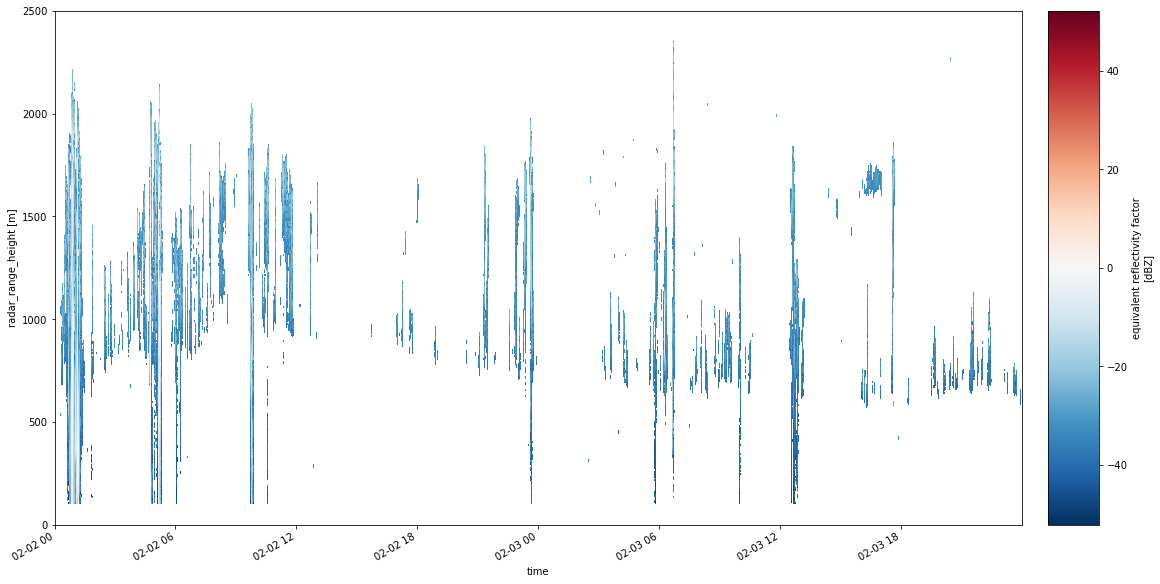

In [17]:
fig, axs = plt.subplots(figsize=(16, 8), constrained_layout=True)
radar_data.radar_reflectivity.plot(x='time', y='height')
axs.set_ylim(0., 2500.)

In [18]:
# reading data containing flags to filter out rainy columns
flag_file_list = np.sort(glob.glob('/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/*_flags_cloud_properties.nc'))
flag_file_list = flag_file_list[13:15]
print(flag_file_list)
data_1 = xr.open_dataset(flag_file_list[0])
data_2 = xr.open_dataset(flag_file_list[1])
data_1 = data_1.drop('cloud_top_height')
data_2 = data_2.drop('cloud_top_height')
flag_data = xr.merge([data_1, data_2]) #, dim='time')

['/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/20200202_flags_cloud_properties.nc'
 '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/20200203_flags_cloud_properties.nc']


/Users/claudia/opt/anaconda3/lib/python3.8/site-packages/xarray/core/alignment.py:307: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  index = joiner(matching_indexes)


<ipython-input-20-2e9aa715ccb3>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh = axs[0].pcolormesh(pd.to_datetime(radar_data['time'].values),\


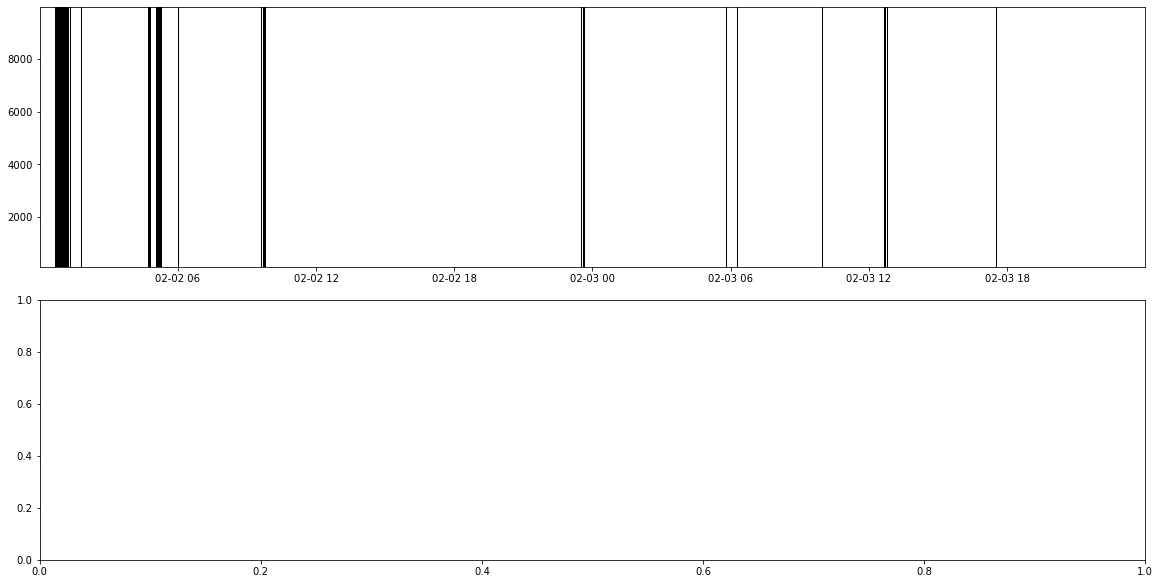

In [20]:
# building a mask to filter out Ze rainy columns and substitute them with nans
# set to nan the values out of the thresholds for the selected variable
mask = np.zeros((len(flag_data.time.values), len(radar_data.height.values)))
for ind in range(len(flag_data.time.values)):
    if (flag_data["flag_rain_ground"].values[ind] == 1) | (flag_data["flag_rain"].values[ind] == 1):
        mask[ind,:] = np.repeat(1, len(radar_data.height.values))
    
fig, axs = plt.subplots(2, 1, figsize=(16, 8), constrained_layout=True)
mesh = axs[0].pcolormesh(pd.to_datetime(radar_data['time'].values),\
                         radar_data['height'].values, \
                         mask.T, cmap='Greys', vmin=0., vmax=1)



In [21]:
radar_data["nans"] = xr.full_like(radar_data.radar_reflectivity, fill_value=np.nan)
radar_data['radar_reflectivity'] = xr.where(mask == 0, radar_data['radar_reflectivity'], radar_data["nans"])
   

(0.0, 2500.0)

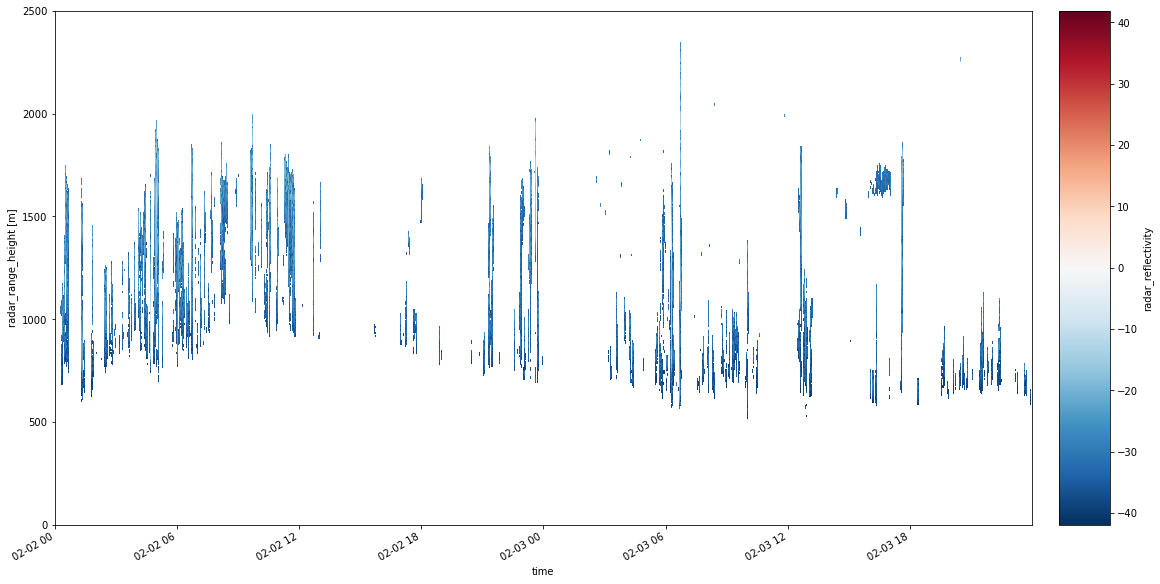

In [22]:
fig, axs = plt.subplots(figsize=(16, 8), constrained_layout=True)
radar_data['radar_reflectivity'].plot(x='time', y='height')
axs.set_ylim(0., 2500.)

In [23]:


# selecting data in the time window of the surface anomaly
radar_data_sliced = radar_data.sel(time=slice(t_start, t_end))




# calculating cloud fraction
from datetime import timedelta

# building SST binned array
SST_min = np.nanmin(sst_tsg)
SST_max = np.nanmax(sst_tsg)
SST_binned_arr_cf = np.arange(SST_min, SST_max, step=0.05)

# calculate label marks for bins
sst_bin_label_cf = []
for ind in range(len(SST_binned_arr_cf)-1):
    sst_bin_label_cf.append(round((SST_binned_arr_cf[ind]+SST_binned_arr_cf[ind+1])/2,2))
    

ze_matrix = radar_data_sliced.radar_reflectivity.values
time_radar = pd.to_datetime(radar_data_sliced.time.values)
time_cloud_fraction = np.arange(time_radar[0], time_radar[-1], timedelta(minutes=15))
dim_time_out = len(time_cloud_fraction)
dim_height = np.shape(ze_matrix)[1]
cloud_fraction = np.zeros((dim_time_out, dim_height))
sst_cf = np.zeros((dim_time_out))

for itime in range(dim_time_out-1):
    data = radar_data_sliced.sel(time=slice(time_cloud_fraction[itime], time_cloud_fraction[itime+1]))
    for iheight in range(dim_height):
        cloud_fraction[itime, iheight] = np.count_nonzero(~np.isnan(data.radar_reflectivity.values[:,iheight]))/np.shape(data.radar_reflectivity.values[:,iheight])[0]

    # calculating corresponding mean SST value associated to the 15 min cloud fraction profile. 
    sst_slice = SST_DS.sel(time=slice(time_cloud_fraction[itime], time_cloud_fraction[itime+1]))
    sst_cf[itime] = sst_slice.SST.mean(dim='time', skipna=True)
    
dims = ['time', 'height']
coords = {'time':time_cloud_fraction, 'height':radar_data_sliced.height.values}
cf = xr.DataArray(dims=dims, coords=coords, data=cloud_fraction,
                 attrs={'long_name':'cloud fraction',
                        'units':''})
sst = xr.DataArray(dims=['time'], coords={'time':time_cloud_fraction}, data=sst_cf,
                 attrs={'long_name':'cloud fraction',
                        'units':''})
variables={'cloud_fraction':cf,
          'SST':sst}

cf_DS =xr.Dataset(data_vars = variables,
                       coords = coords)

# calculating mean quantities f
dataset_mean = []
dataset_std = []

# selecting all columns in the bin interval
for ind_bin in range(len(SST_binned_arr_cf)-1):

    # selecting slices of datasets columns with SST values in the selected bin
    DS_sliced = cf_DS.where((cf_DS.SST > SST_binned_arr_cf[ind_bin]) & (cf_DS.SST < SST_binned_arr_cf[ind_bin+1]), drop=True)

    # add variable of the number of elements of the slice
    n_el = len(DS_sliced.SST.values)
    DS_sliced['n_elements'] = n_el

    # calculate mean profile averaging all selected time stamps together
    dataset_mean.append(DS_sliced.mean(dim='time', skipna=True))
    dataset_std.append(DS_sliced.std(dim='time', skipna=True))

# concatenating datasets corresponding to SST bins on a new bin dimension
cloud_fraction_concat = xr.concat([dataset_mean[i] for i in np.arange(len(dataset_mean))], dim='SST_binned')
cloud_fraction_std_concat = xr.concat([dataset_std[i] for i in np.arange(len(dataset_std))], dim='SST_binned')



<ipython-input-26-8dde911a2d33>:33: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh = axs[0,0].pcolormesh(sst_bin_label, dataset_out.height.values, dataset_out.MR.values.T, cmap='inferno', vmin=-5., vmax=5)
<ipython-input-26-8dde911a2d33>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh = axs[0,1].pcolormesh(sst_bin_label, dataset_out.height.values, dataset_out.T.values.T, cmap='rainbow', vmin=-5., vmax=5.)
<ipython-input-26-8dde911a2d33>:44: Matplo

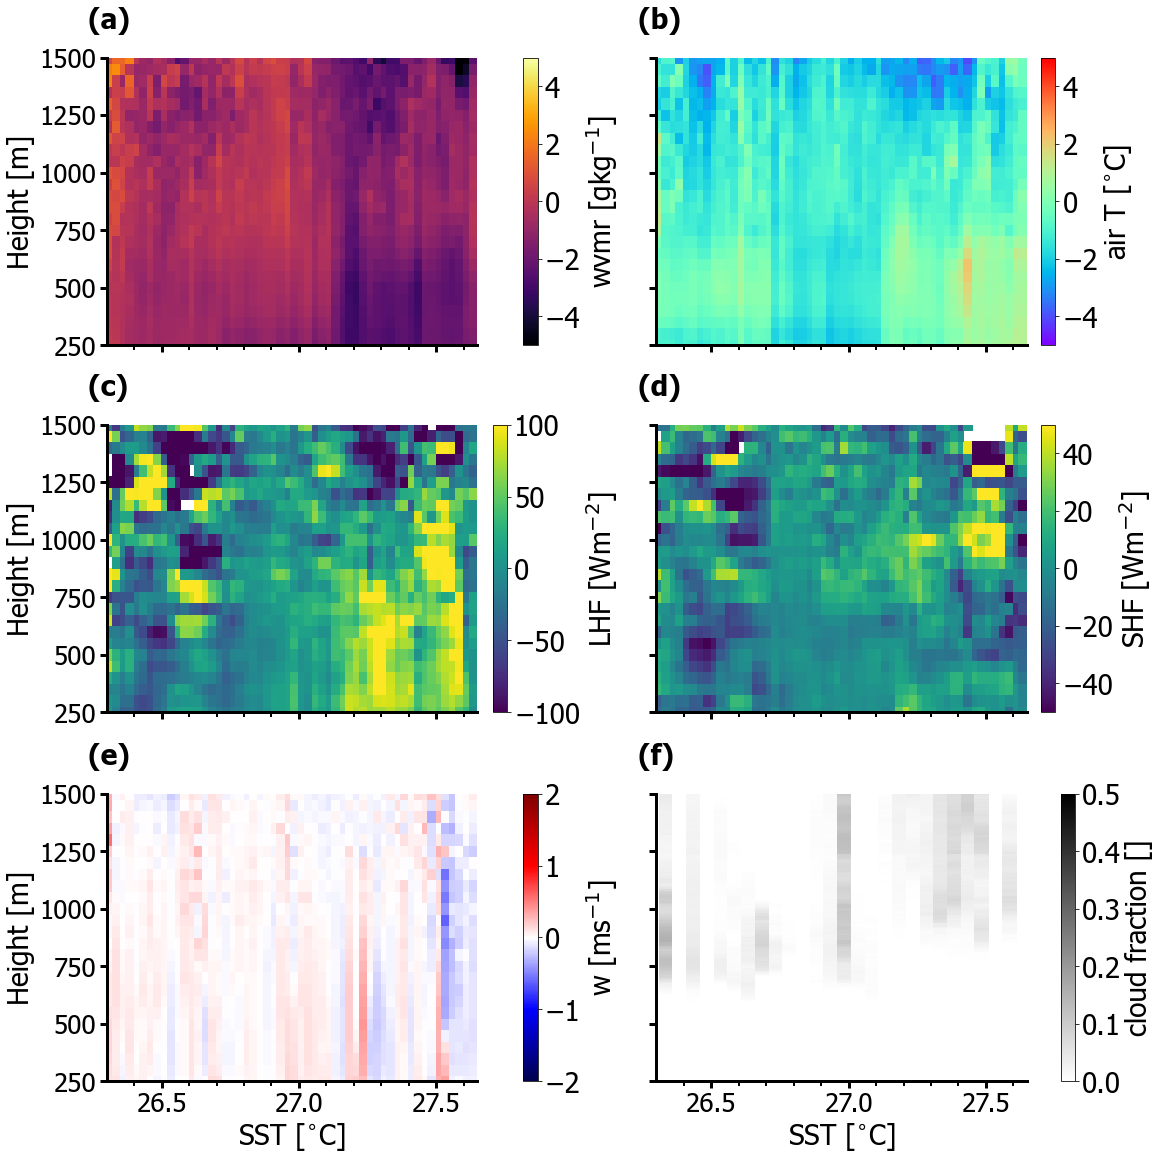

In [26]:
dict_plot_settings = {
    'labelsizeaxes':14,
    'fontSizeTitle':16,
    'fontSizeX'    :28,
    'fontSizeY'    :28,
    'cbarAspect'   :10,
    'fontSizeCbar' :28,
    'rcparams_font':['Tahoma'],
    'savefig_dpi'  :100,
    'font_size'    :28, 
    'grid'         :True}


# composite figure variables binned in sst 
path_out_plots = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/SST_impact_work/plots/'

# plots settings defined by user at the top
labelsizeaxes   = dict_plot_settings['labelsizeaxes']
fontSizeTitle   = dict_plot_settings['fontSizeTitle']
fontSizeX       = dict_plot_settings['fontSizeX']
fontSizeY       = dict_plot_settings['fontSizeY']
cbarAspect      = dict_plot_settings['cbarAspect']
fontSizeCbar    = dict_plot_settings['fontSizeCbar']
rcParams['font.sans-serif'] = dict_plot_settings['rcparams_font']
matplotlib.rcParams['savefig.dpi'] = dict_plot_settings['savefig_dpi']
plt.rcParams.update({'font.size':dict_plot_settings['font_size']})
grid = dict_plot_settings['grid']

fig, axs = plt.subplots(3, 2, figsize=(16,16), sharey=True, sharex=True, constrained_layout=True)

green_diamond = dict(markerfacecolor='b', marker='D')

mesh = axs[0,0].pcolormesh(sst_bin_label, dataset_out.height.values, dataset_out.MR.values.T, cmap='inferno', vmin=-5., vmax=5)
cbar = fig.colorbar(mesh, ax=axs[0,0])
cbar.set_label(label='wvmr [gkg$^{-1}$]',  size=fontSizeX)
axs[0,0].set_ylabel('Height [m]', fontsize=fontSizeX)
axs[0,0].set_ylim(200,1500)

mesh = axs[0,1].pcolormesh(sst_bin_label, dataset_out.height.values, dataset_out.T.values.T, cmap='rainbow', vmin=-5., vmax=5.)
cbar = fig.colorbar(mesh, ax=axs[0,1])
cbar.set_label(label='air T [$^{\circ}$C]',  size=fontSizeX)
axs[0,1].set_ylim(200,1500)

mesh = axs[1,0].pcolormesh(sst_bin_label, dataset_out.height.values, dataset_out.LHF.values.T, cmap='viridis', vmin=-100., vmax=100.)
cbar = fig.colorbar(mesh, ax=axs[1,0])
cbar.set_label(label='LHF [Wm$^{-2}$]',  size=fontSizeX)
axs[1,0].set_ylabel('Height [m]', fontsize=fontSizeX)
axs[1,0].set_ylim(200,1500)

mesh = axs[1,1].pcolormesh(sst_bin_label, dataset_out.height.values, dataset_out.SHF.values.T, cmap='viridis', vmin=-50., vmax=50.)
cbar = fig.colorbar(mesh, ax=axs[1,1])
cbar.set_label(label='SHF [Wm$^{-2}$]', size=fontSizeX)
axs[1,1].set_ylim(200,1500)


mesh = axs[2,0].pcolormesh(sst_bin_label, dataset_out.height.values, dataset_out.VW.values.T, cmap='seismic', vmin=-2., vmax=2.)
cbar = fig.colorbar(mesh, ax=axs[2,0])
cbar.set_label(label='w [ms$^{-1}$]',  size=fontSizeX)
axs[2,0].set_ylabel('Height [m]', fontsize=fontSizeX)
axs[2,0].set_xlabel('SST [$^{\circ}$C]', fontsize=fontSizeX)



mesh = axs[2,1].pcolormesh(sst_bin_label_cf, cloud_fraction_concat.height.values, cloud_fraction_concat.cloud_fraction.values.T, cmap='binary', vmin=0., vmax=0.5)
cbar = fig.colorbar(mesh, ax=axs[2,1])
cbar.set_label(label='cloud fraction []',  size=fontSizeX)
axs[2,1].set_xlabel('SST [$^{\circ}$C]', fontsize=fontSizeX)


count = 0
for ax, l in zip(axs[:].flatten(), ['(a) ',  '(b) ',  '(c) ',  '(d) ', '(e) ', '(f) ']):
    ax.text(-0.05, 1.1, l,  fontweight='black', fontsize=fontSizeX, transform=ax.transAxes)
    #ax.set_xlim(SST_binned_arr[0]-0.1, SST_binned_arr[-1]+0.1)
    
    ax.set_ylim(250.,1500.)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_linewidth(3)
    ax.spines["left"].set_linewidth(3)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.tick_params(which='minor', length=5, width=2)
    ax.tick_params(which='major', length=7, width=3)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.tick_params(axis='both', labelsize=26)
    #ax.grid(True, which='both', color='grey', linestyle=':')
    count = count+1
fig.savefig(path_out_plots+'profile_lidars_binned_sst.png')

In [27]:
path_out_plots

'/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/SST_impact_work/plots/'

In [43]:
# applying interpolating and binning functions to Horizontal wind data

H_wind_SST = f_interpolate_SST_and_merge(SST_DS, H_wind_DS)
#f_calculate_binned_data(H_wind_DS, SST_binned_arr)
# calculating mean quantities f
dataset_mean = []
dataset_std = []


# selecting all columns in the bin interval
for ind_bin in range(len(SST_binned_arr)-1):

    # selecting slices of datasets columns with SST values in the selected bin
    DS_sliced = H_wind_SST.where((H_wind_SST.SST > SST_binned_arr[ind_bin]) & (H_wind_SST.SST < SST_binned_arr[ind_bin+1]), drop=True)

    # add variable of the number of elements of the slice
    n_el = len(DS_sliced.SST.values)
    DS_sliced['n_elements'] = n_el

    # calculate mean profile averaging all selected time stamps together
    dataset_mean.append(DS_sliced.mean(dim='time', skipna=True))
    dataset_std.append(DS_sliced.std(dim='time', skipna=True))

# concatenating datasets corresponding to SST bins on a new bin dimension
H_wind_concat = xr.concat([dataset_mean[i] for i in np.arange(len(dataset_mean))], dim='SST_binned')
H_wind_std_concat = xr.concat([dataset_std[i] for i in np.arange(len(dataset_std))], dim='SST_binned')


In [11]:
# applying interpolating and binning functions to Horizontal wind data

V_wind_SST = f_interpolate_SST_and_merge(SST_DS, w_wind_DS)
#f_calculate_binned_data(H_wind_DS, SST_binned_arr)
# calculating mean quantities f
dataset_mean = []
dataset_std = []

# selecting all columns in the bin interval
for ind_bin in range(len(SST_binned_arr)-1):

    # selecting slices of datasets columns with SST values in the selected bin
    DS_sliced = V_wind_SST.where((V_wind_SST.SST > SST_binned_arr[ind_bin]) & (V_wind_SST.SST < SST_binned_arr[ind_bin+1]), drop=True)

    # add variable of the number of elements of the slice
    n_el = len(DS_sliced.SST.values)
    DS_sliced['n_elements'] = n_el

    # calculate mean profile averaging all selected time stamps together
    dataset_mean.append(DS_sliced.mean(dim='time', skipna=True))
    dataset_std.append(DS_sliced.std(dim='time', skipna=True))


# concatenating datasets corresponding to SST bins on a new bin dimension
V_wind_concat = xr.concat([dataset_mean[i] for i in np.arange(len(dataset_mean))], dim='SST_binned')
V_wind_concat.assign_coords({"SST_binned": sst_bin_label})
V_wind_std_concat = xr.concat([dataset_std[i] for i in np.arange(len(dataset_std))], dim='SST_binned')


reading and processing cloud radar data with cloud fraction calculation 

<ipython-input-30-0b2ad987435e>:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh = axs[0,0].pcolormesh(sst_bin_label, arthus_all_concat.height.values, arthus_all_concat.Water_vapor_mixing_ratio.values.T, cmap='inferno', vmin=0., vmax=15)
<ipython-input-30-0b2ad987435e>:29: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh = axs[0,1].pcolormesh(sst_bin_label, arthus_all_concat.height.values, arthus_all_concat.Temperature.values.T, cmap='rainbow', vmin=

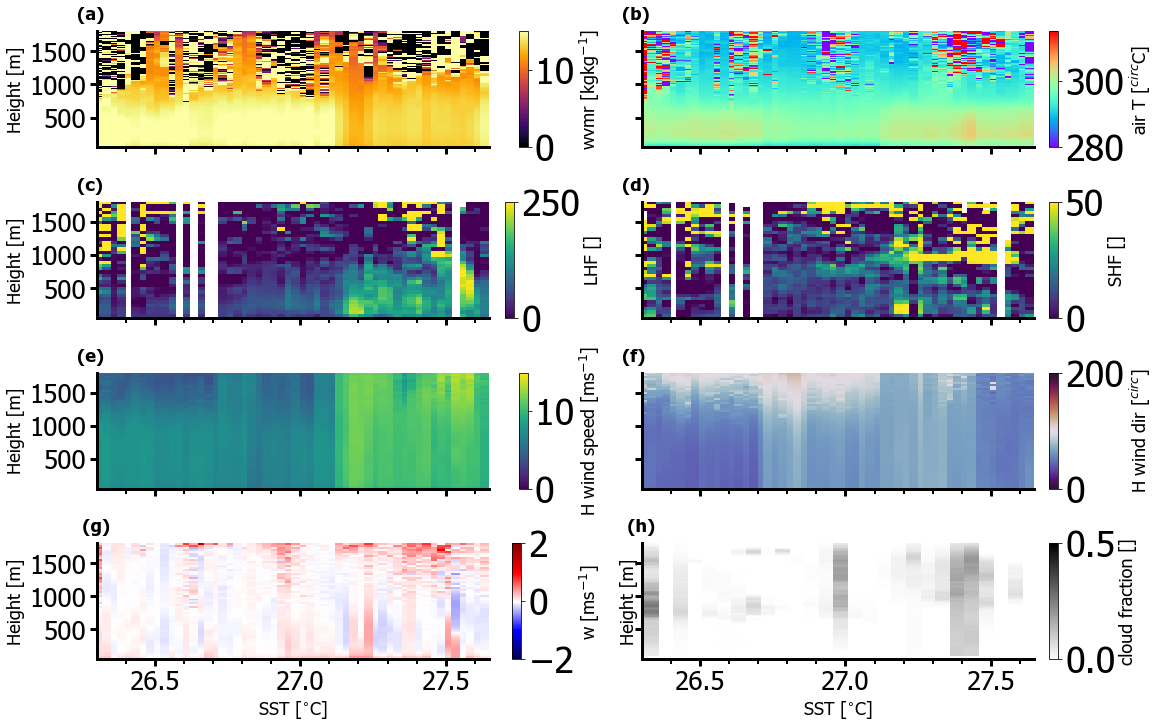

In [30]:
# composite figure variables binned in sst 

path_RS = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/radiosondes_atalante/case_1/'
font = {'family' : 'Tahoma',
        'weight' : 'normal',
        'size'   : 18}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(4, 2, figsize=(16,10), sharey=True, sharex=True, constrained_layout=True)
grid = True
matplotlib.rc('xtick', labelsize=36)  # sets dimension of ticks in the plots
matplotlib.rc('ytick', labelsize=36) # sets dimension of ticks in the plots
val = 18
labelsizeaxes   = val
fontSizeTitle   = val
fontSizeX       = val
fontSizeY       = val
cbarAspect      = val
fontSizeCbar    = val
green_diamond = dict(markerfacecolor='b', marker='D')

mesh = axs[0,0].pcolormesh(sst_bin_label, arthus_all_concat.height.values, arthus_all_concat.Water_vapor_mixing_ratio.values.T, cmap='inferno', vmin=0., vmax=15)
#arthus_all_concat.Water_vapor_mixing_ratio.plot(x='SST_binned', y='height', vmin=0., vmax=15., ax=axs[0,0])
#plt.ylim(50., 1000.)#axs[0].set_xlim(290.,325.)
cbar = fig.colorbar(mesh, ax=axs[0,0])
cbar.set_label(label='wvmr [kgkg$^{-1}$]',  size=fontSizeX)
axs[0,0].set_ylabel('Height [m]', fontsize=fontSizeX)
axs[0,0].set_ylim(200,1500)

mesh = axs[0,1].pcolormesh(sst_bin_label, arthus_all_concat.height.values, arthus_all_concat.Temperature.values.T, cmap='rainbow', vmin=280., vmax=315.)
#arthus_all_concat.Water_vapor_mixing_ratio.plot(x='SST_binned', y='height', vmin=0., vmax=15., ax=axs[0,0])
#plt.ylim(50., 1000.)#axs[0].set_xlim(290.,325.)
cbar = fig.colorbar(mesh, ax=axs[0,1])
cbar.set_label(label='air T [$^{circ}$C]',  size=fontSizeX)
axs[0,1].set_ylim(200,1500)

mesh = axs[1,0].pcolormesh(sst_bin_label, arthus_fluxes_concat.height.values, arthus_fluxes_concat.Latent_heat_flux.values.T, cmap='viridis', vmin=0., vmax=250.)
#arthus_all_concat.Water_vapor_mixing_ratio.plot(x='SST_binned', y='height', vmin=0., vmax=15., ax=axs[0,0])
#plt.ylim(50., 1000.)#axs[0].set_xlim(290.,325.)
cbar = fig.colorbar(mesh, ax=axs[1,0])
cbar.set_label(label='LHF []',  size=fontSizeX)
axs[1,0].set_ylabel('Height [m]', fontsize=fontSizeX)
axs[1,0].set_ylim(200,1500)

mesh = axs[1,1].pcolormesh(sst_bin_label, arthus_fluxes_concat.height.values, arthus_fluxes_concat.Sensible_heat_flux.values.T, cmap='viridis', vmin=0., vmax=50.)
#arthus_all_concat.Water_vapor_mixing_ratio.plot(x='SST_binned', y='height', vmin=0., vmax=15., ax=axs[0,0])
#plt.ylim(50., 1000.)#axs[0].set_xlim(290.,325.)
cbar = fig.colorbar(mesh, ax=axs[1,1])
cbar.set_label(label='SHF []', size=fontSizeX)
axs[1,1].set_ylim(200,1500)


mesh = axs[2,0].pcolormesh(sst_bin_label, H_wind_concat.height.values, H_wind_concat.Horizontal_Wind_Speed.values.T, cmap='viridis', vmin=0., vmax=15.)
#arthus_all_concat.Water_vapor_mixing_ratio.plot(x='SST_binned', y='height', vmin=0., vmax=15., ax=axs[0,0])
#plt.ylim(50., 1000.)#axs[0].set_xlim(290.,325.)
cbar = fig.colorbar(mesh, ax=axs[2,0])
cbar.set_label(label='H wind speed [ms$^{-1}$]',  size=fontSizeX)
axs[2,0].set_ylabel('Height [m]', fontsize=fontSizeX)

mesh = axs[2,1].pcolormesh(sst_bin_label, H_wind_concat.height.values, H_wind_concat.Horizontal_Wind_Direction.values.T, cmap='twilight_shifted', vmin=0., vmax=200.)
#arthus_all_concat.Water_vapor_mixing_ratio.plot(x='SST_binned', y='height', vmin=0., vmax=15., ax=axs[0,0])
#plt.ylim(50., 1000.)#axs[0].set_xlim(290.,325.)
cbar = fig.colorbar(mesh, ax=axs[2,1])
cbar.set_label(label='H wind dir [$^{circ}$]',  size=fontSizeX)


mesh = axs[3,0].pcolormesh(sst_bin_label, V_wind_concat.height.values, V_wind_concat.w.values.T, cmap='seismic', vmin=-2., vmax=2.)
#arthus_all_concat.Water_vapor_mixing_ratio.plot(x='SST_binned', y='height', vmin=0., vmax=15., ax=axs[0,0])
#plt.ylim(50., 1000.)#axs[0].set_xlim(290.,325.)
cbar = fig.colorbar(mesh, ax=axs[3,0])
cbar.set_label(label='w [ms$^{-1}$]',  size=fontSizeX)
axs[3,0].set_ylabel('Height [m]', fontsize=fontSizeX)
axs[3,0].set_xlabel('SST [$^{\circ}$C]', fontsize=fontSizeX)



mesh = axs[3,1].pcolormesh(sst_bin_label_cf, cloud_fraction_concat.height.values, cloud_fraction_concat.cloud_fraction.values.T, cmap='binary', vmin=0., vmax=0.5)
#arthus_all_concat.Water_vapor_mixing_ratio.plot(x='SST_binned', y='height', vmin=0., vmax=15., ax=axs[0,0])
#plt.ylim(50., 1000.)#axs[0].set_xlim(290.,325.)
cbar = fig.colorbar(mesh, ax=axs[3,1])
cbar.set_label(label='cloud fraction []',  size=fontSizeX)
axs[3,1].set_ylabel('Height [m]', fontsize=fontSizeX)
axs[3,1].set_xlabel('SST [$^{\circ}$C]', fontsize=fontSizeX)


#axs[3,1].plot(sst_bin_label, V_wind_concat.cb.values, marker="v", label='cloud base height')
#axs[3,1].legend(frameon=False)
#axs[3,1].set_xlabel('SST [$^{\circ}$]', fontsize=fontSizeX)

count = 0
for ax, l in zip(axs[:].flatten(), ['(a) ',  '(b) ',  '(c) ',  '(d) ', '(e) ', '(f) ', ' (g)', ' (h)']):
    ax.text(-0.05, 1.1, l,  fontweight='black', fontsize=val, transform=ax.transAxes)
    #ax.set_xlim(SST_binned_arr[0]-0.1, SST_binned_arr[-1]+0.1)
    
    ax.set_ylim(50,1800)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_linewidth(3)
    ax.spines["left"].set_linewidth(3)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.tick_params(which='minor', length=5, width=2)
    ax.tick_params(which='major', length=7, width=3)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.tick_params(axis='both', labelsize=26)
    #ax.grid(True, which='both', color='grey', linestyle=':')
    count = count+1
fig.savefig(path_RS+'profile_lidars_binned_sst.png')

In [14]:
SST_binned_arr

array([26.283, 26.308, 26.333, 26.358, 26.383, 26.408, 26.433, 26.458,
       26.483, 26.508, 26.533, 26.558, 26.583, 26.608, 26.633, 26.658,
       26.683, 26.708, 26.733, 26.758, 26.783, 26.808, 26.833, 26.858,
       26.883, 26.908, 26.933, 26.958, 26.983, 27.008, 27.033, 27.058,
       27.083, 27.108, 27.133, 27.158, 27.183, 27.208, 27.233, 27.258,
       27.283, 27.308, 27.333, 27.358, 27.383, 27.408, 27.433, 27.458,
       27.483, 27.508, 27.533, 27.558, 27.583, 27.608, 27.633, 27.658])

<ipython-input-32-6bdd0883b913>:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh = axs[0,0].pcolormesh(sst_bin_label, arthus_all_std_concat.height.values, arthus_all_std_concat.Water_vapor_mixing_ratio.values.T, cmap='inferno', vmin=0., vmax=2.5)
<ipython-input-32-6bdd0883b913>:29: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh = axs[0,1].pcolormesh(sst_bin_label, arthus_all_std_concat.height.values, arthus_all_std_concat.Temperature.values.T, cmap

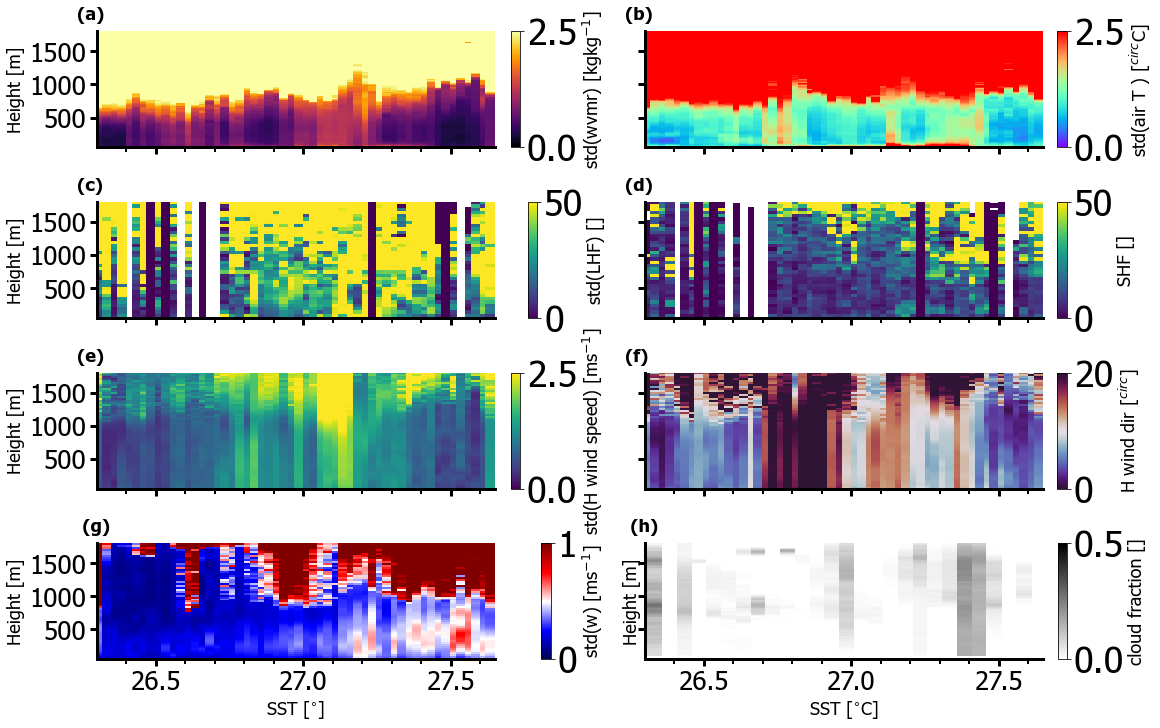

In [32]:
# composite figure standard deviation of variables binned in sst 

path_RS = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/radiosondes_atalante/case_1/'
font = {'family' : 'Tahoma',
        'weight' : 'normal',
        'size'   : 18}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(4, 2, figsize=(16,10), sharey=True, sharex=True, constrained_layout=True)
grid = True
matplotlib.rc('xtick', labelsize=36)  # sets dimension of ticks in the plots
matplotlib.rc('ytick', labelsize=36) # sets dimension of ticks in the plots
val = 18
labelsizeaxes   = val
fontSizeTitle   = val
fontSizeX       = val
fontSizeY       = val
cbarAspect      = val
fontSizeCbar    = val
green_diamond = dict(markerfacecolor='b', marker='D')

mesh = axs[0,0].pcolormesh(sst_bin_label, arthus_all_std_concat.height.values, arthus_all_std_concat.Water_vapor_mixing_ratio.values.T, cmap='inferno', vmin=0., vmax=2.5)
#arthus_all_concat.Water_vapor_mixing_ratio.plot(x='SST_binned', y='height', vmin=0., vmax=15., ax=axs[0,0])
#plt.ylim(50., 1000.)#axs[0].set_xlim(290.,325.)
cbar = fig.colorbar(mesh, ax=axs[0,0])
cbar.set_label(label='std(wvmr) [kgkg$^{-1}$]',  size=fontSizeX)
axs[0,0].set_ylabel('Height [m]', fontsize=fontSizeX)
axs[0,0].set_ylim(200,1500)

mesh = axs[0,1].pcolormesh(sst_bin_label, arthus_all_std_concat.height.values, arthus_all_std_concat.Temperature.values.T, cmap='rainbow', vmin=0., vmax=2.5)
#arthus_all_concat.Water_vapor_mixing_ratio.plot(x='SST_binned', y='height', vmin=0., vmax=15., ax=axs[0,0])
#plt.ylim(50., 1000.)#axs[0].set_xlim(290.,325.)
cbar = fig.colorbar(mesh, ax=axs[0,1])
cbar.set_label(label='std(air T ) [$^{circ}$C]',  size=fontSizeX)
axs[0,1].set_ylim(200,1500)

mesh = axs[1,0].pcolormesh(sst_bin_label, arthus_fluxes_std_concat.height.values, arthus_fluxes_std_concat.Latent_heat_flux.values.T, cmap='viridis', vmin=0., vmax=50.)
#arthus_all_concat.Water_vapor_mixing_ratio.plot(x='SST_binned', y='height', vmin=0., vmax=15., ax=axs[0,0])
#plt.ylim(50., 1000.)#axs[0].set_xlim(290.,325.)
cbar = fig.colorbar(mesh, ax=axs[1,0])
cbar.set_label(label='std(LHF) []',  size=fontSizeX)
axs[1,0].set_ylabel('Height [m]', fontsize=fontSizeX)
axs[1,0].set_ylim(200,1500)

mesh = axs[1,1].pcolormesh(sst_bin_label, arthus_fluxes_std_concat.height.values, arthus_fluxes_std_concat.Sensible_heat_flux.values.T, cmap='viridis', vmin=0., vmax=50.)
#arthus_all_concat.Water_vapor_mixing_ratio.plot(x='SST_binned', y='height', vmin=0., vmax=15., ax=axs[0,0])
#plt.ylim(50., 1000.)#axs[0].set_xlim(290.,325.)
cbar = fig.colorbar(mesh, ax=axs[1,1])
cbar.set_label(label='SHF []', size=fontSizeX)
axs[1,1].set_ylim(200,1500)


mesh = axs[2,0].pcolormesh(sst_bin_label, H_wind_std_concat.height.values, H_wind_std_concat.Horizontal_Wind_Speed.values.T, cmap='viridis', vmin=0., vmax=2.5)
#arthus_all_concat.Water_vapor_mixing_ratio.plot(x='SST_binned', y='height', vmin=0., vmax=15., ax=axs[0,0])
#plt.ylim(50., 1000.)#axs[0].set_xlim(290.,325.)
cbar = fig.colorbar(mesh, ax=axs[2,0])
cbar.set_label(label='std(H wind speed) [ms$^{-1}$]',  size=fontSizeX)
axs[2,0].set_ylabel('Height [m]', fontsize=fontSizeX)

mesh = axs[2,1].pcolormesh(sst_bin_label, H_wind_std_concat.height.values, H_wind_std_concat.Horizontal_Wind_Direction.values.T, cmap='twilight_shifted', vmin=0., vmax=20.)
#arthus_all_concat.Water_vapor_mixing_ratio.plot(x='SST_binned', y='height', vmin=0., vmax=15., ax=axs[0,0])
#plt.ylim(50., 1000.)#axs[0].set_xlim(290.,325.)
cbar = fig.colorbar(mesh, ax=axs[2,1])
cbar.set_label(label='H wind dir [$^{circ}$]',  size=fontSizeX)


mesh = axs[3,0].pcolormesh(sst_bin_label, V_wind_std_concat.height.values, V_wind_std_concat.w.values.T, cmap='seismic', vmin=0., vmax=1.)
#arthus_all_concat.Water_vapor_mixing_ratio.plot(x='SST_binned', y='height', vmin=0., vmax=15., ax=axs[0,0])
#plt.ylim(50., 1000.)#axs[0].set_xlim(290.,325.)
cbar = fig.colorbar(mesh, ax=axs[3,0])
cbar.set_label(label='std(w) [ms$^{-1}$]',  size=fontSizeX)
axs[3,0].set_ylabel('Height [m]', fontsize=fontSizeX)
axs[3,0].set_xlabel('SST [$^{\circ}$]', fontsize=fontSizeX)

#axs[3,1].plot(sst_bin_label, V_wind_std_concat.cb.values, marker="v", label='cloud base height')
#axs[3,1].legend(frameon=False)
#axs[3,1].set_xlabel('SST [$^{\circ}$]', fontsize=fontSizeX)


mesh = axs[3,1].pcolormesh(sst_bin_label_cf, cloud_fraction_std_concat.height.values, cloud_fraction_std_concat.cloud_fraction.values.T, cmap='binary', vmin=0., vmax=0.5)
#arthus_all_concat.Water_vapor_mixing_ratio.plot(x='SST_binned', y='height', vmin=0., vmax=15., ax=axs[0,0])
#plt.ylim(50., 1000.)#axs[0].set_xlim(290.,325.)
cbar = fig.colorbar(mesh, ax=axs[3,1])
cbar.set_label(label='cloud fraction []',  size=fontSizeX)
axs[3,1].set_ylabel('Height [m]', fontsize=fontSizeX)
axs[3,1].set_xlabel('SST [$^{\circ}$C]', fontsize=fontSizeX)

count = 0
for ax, l in zip(axs[:].flatten(), ['(a) ',  '(b) ',  '(c) ',  '(d) ', '(e) ', '(f) ', ' (g)', ' (h)']):
    ax.text(-0.05, 1.1, l,  fontweight='black', fontsize=val, transform=ax.transAxes)
    #ax.set_xlim(SST_binned_arr[0]-0.1, SST_binned_arr[-1]+0.1)
    
    ax.set_ylim(50,1800)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_linewidth(3)
    ax.spines["left"].set_linewidth(3)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.tick_params(which='minor', length=5, width=2)
    ax.tick_params(which='major', length=7, width=3)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.tick_params(axis='both', labelsize=26)
    #ax.grid(True, which='both', color='grey', linestyle=':')
    count = count+1
fig.savefig(path_RS+'profile_lidars_std_binned_sst.png')